<a href="https://colab.research.google.com/github/outliers8224/Deeplearning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU available")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available")

No GPU available


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
!pip install Augmentor

In [ ]:
import os
import Augmentor
import shutil
from PIL import Image

In [ ]:
!git clone https://github.com/makhan010385/Soybean-.git

Cloning into 'Soybean-'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 404 (delta 1), reused 53 (delta 0), pack-reused 347
Receiving objects: 100% (404/404), 1.75 GiB | 33.68 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (355/355), done.


In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Soybean-",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 345 files belonging to 2 classes.


In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Soybean-",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 345 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Soybean Leaf Dataset for Disease Classification',
 'Soybean Seeds Stage Prediction']

In [ ]:
print("Tensor Object")
train_data.take(1)

Tensor Object


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

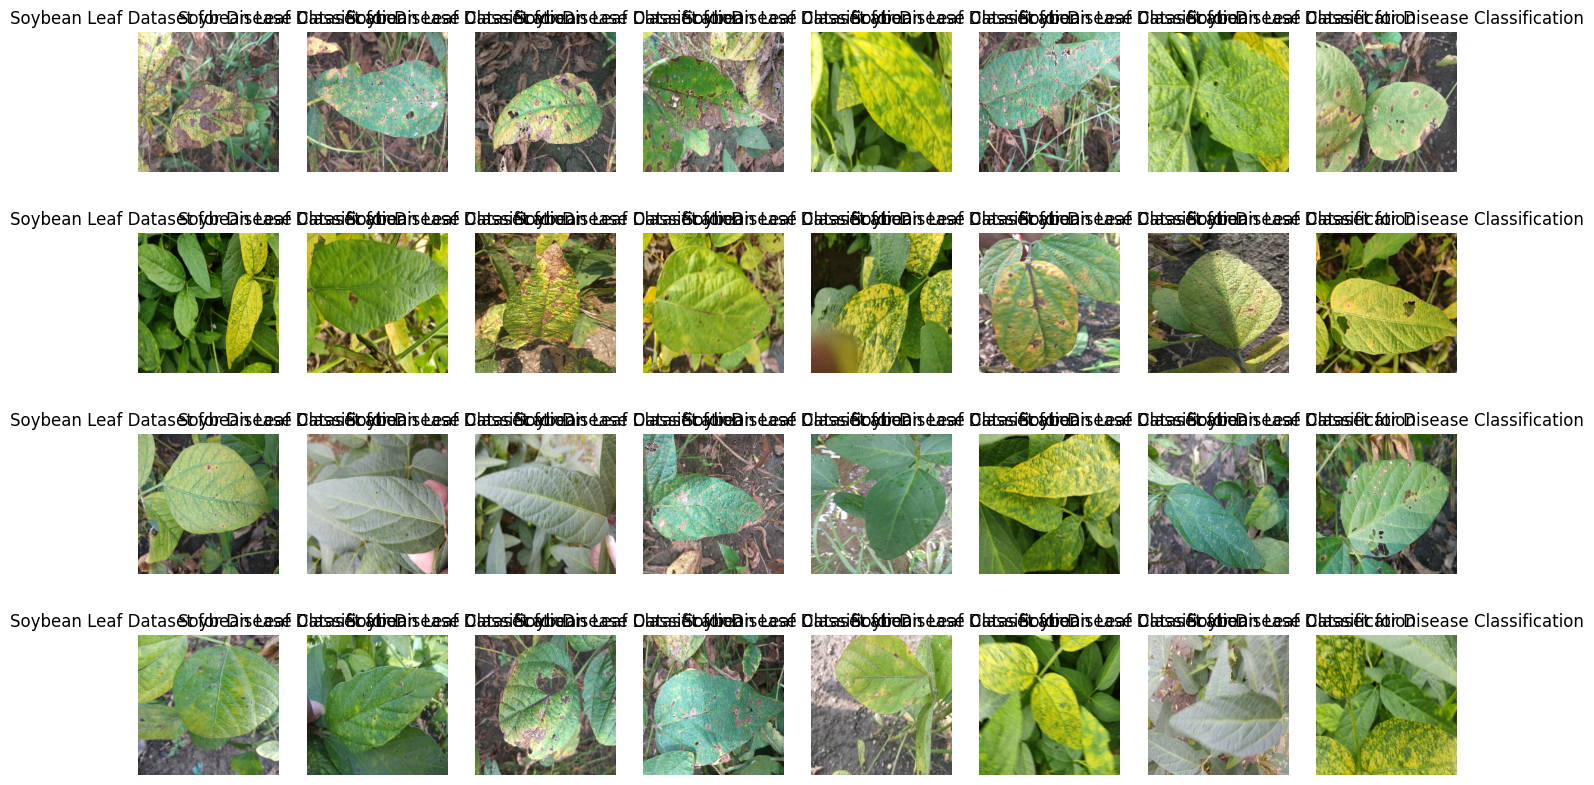

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,10))

for image_batch, label_batch in train_data.take(1):

    for i in range(image_batch.shape[0]):

        ax = plt.subplot(4,8,i+1)   # 4 rows, 8 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partition_tf( ds, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=100):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle( shuffle_size, seed=12 )

  val_size = int( val_split * ds_size )

  val_ds = ds.skip( val_size )
  test_ds = ds.skip( val_size )

  return test_ds, val_ds

In [ ]:
test_ds, val_ds = get_dataset_partition_tf( test_data, test_split = 0.5, val_split = 0.5 )

print( "Training Batches :", len(train_data) )
print( "Testing Batches :", len(test_ds) )
print( "validation Batches :", len(val_ds) )

Training Batches : 11
Testing Batches : 6
validation Batches : 6


In [ ]:
train_ds = train_data.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )
test_ds = test_ds.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )
val_ds = val_ds.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )

In [ ]:
from tensorflow.keras import models, layers, applications

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing( IMAGE_SIZE, IMAGE_SIZE ),
    layers.experimental.preprocessing.Rescaling( 1.0/255 )
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

from tensorflow.keras import models, layers

model = models.Sequential([

    resize_and_rescale,
    # data_augmentation,

    layers.Conv2D(32, (4, 4), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Adding dropout with 25% probability of dropout

    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout with 50% probability of dropout
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 126, 126, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 123, 123, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 61, 61, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience= 5,
    verbose=1,
)
model_checkpoint = ModelCheckpoint(
    filepath="./cnn_model3.h5", #change model saved
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
)
model_callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size= BATCH_SIZE,
    verbose =1,
    validation_data=val_ds,
    callbacks=model_callbacks,
)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9391
Epoch 1: val_loss improved from inf to 0.00000, saving model to ./cnn_model3.h5
11/11 [==============================] - 202s 14s/step - loss: 0.1507 - accuracy: 0.9391 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
11/11 [==============================] - 71s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00000
11/11 [==============================] - 70s 6s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.00000
11/11 [==============================] - 71s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
11/11 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5: val_loss did not improve from 0.00000
11/11 [=============

In [ ]:
score = model.evaluate(test_ds)

6/6 [==============================] - 58s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
def pesticidee(img_name):
    if img_name=='Anthracnose':
        return('sol ')
    elif img_name=='Rust':
        return('furadan applicatio')
    elif img_name=='Bacterial postule':
        return('Spray 2.5kg of carbaryl')
    elif img_name=='FLS':
        return('sol')
    elif img_name=='Sudden Death Syndrome':
        return('Buprofezin 25% SC')
    elif img_name=='Yellow Mosaic':
        return('Permethrin, bifenthrin, lambda cyhalothrin and carbaryl')





In [ ]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   #convert image into array
    img_array = tf.expand_dims(img_array, 0)                  # creat a batch

    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    Pesticidee = pesticidee(predicted_class)
    return predicted_class, confidence , Pesticidee

In [ ]:
plt.figure(figsize=(20,23))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence , Pesticidee = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%,\n Solution: {Pesticidee}")

        plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from matplotlib import pyplot as plt

image_path = r'Soybean-/Soybean Leaf Dataset for Disease Classification/Bacterial Pustule, Soybean Leaf Dataset for Disease Classification/Bacterial Pustule,BP (1).jpg'


#load
image = load_img(image_path , target_size=(IMAGE_SIZE , IMAGE_SIZE))
img_array = img_to_array(image)   #convert image into array
img_array = tf.expand_dims(img_array, 0)                  # creat a batch

predictions = model.predict(img_array)
print(predictions)
predicted_class = class_names[np.argmax(predictions)]

confidence = round(100 * (np.max(predictions)), 2)
Pesticidee = pesticidee(predicted_class)

plt.imshow(image)
plt.title(f"Predicted class : {predicted_class}\n Confidence: {confidence}% \n Pesticide: {Pesticidee}" )
plt.axis('off')
